In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import img_to_array, load_img


from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from skimage import exposure
from skimage import color

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, Adamax
from keras.layers import Input, UpSampling2D, Conv2D, concatenate, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import load_img, img_to_array
from keras.regularizers import l1, l2

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input # Changed import path

import os
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [2]:
import os
import pandas as pd

import shutil


original_csv_path = 'metadata - standardized.csv'

original_df = pd.read_csv(original_csv_path)

In [3]:

df = original_df[['names', 'types']]

df = df[df['types'] != -1]


df['types'].value_counts()


types
0    7549
1    4767
Name: count, dtype: int64

In [4]:
df.head()

,names,types
0,OIA-ODIR-TEST-OFFLINE-1,0
1,OIA-ODIR-TEST-OFFLINE-2,0
2,OIA-ODIR-TEST-OFFLINE-4,0
3,OIA-ODIR-TEST-OFFLINE-5,0
4,OIA-ODIR-TEST-OFFLINE-6,0


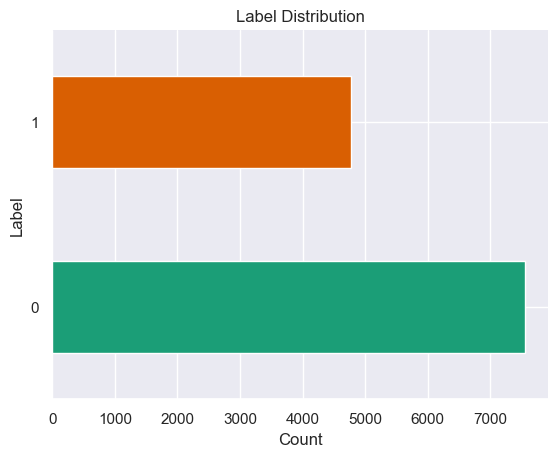

In [7]:
import matplotlib.pyplot as plt

# Group by 'label' and count the occurrences, then plot as a horizontal bar chart
df.groupby('types').size().plot(kind='barh', color=sns.color_palette('Dark2'))

# Customize the plot to match the style
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Label Distribution')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


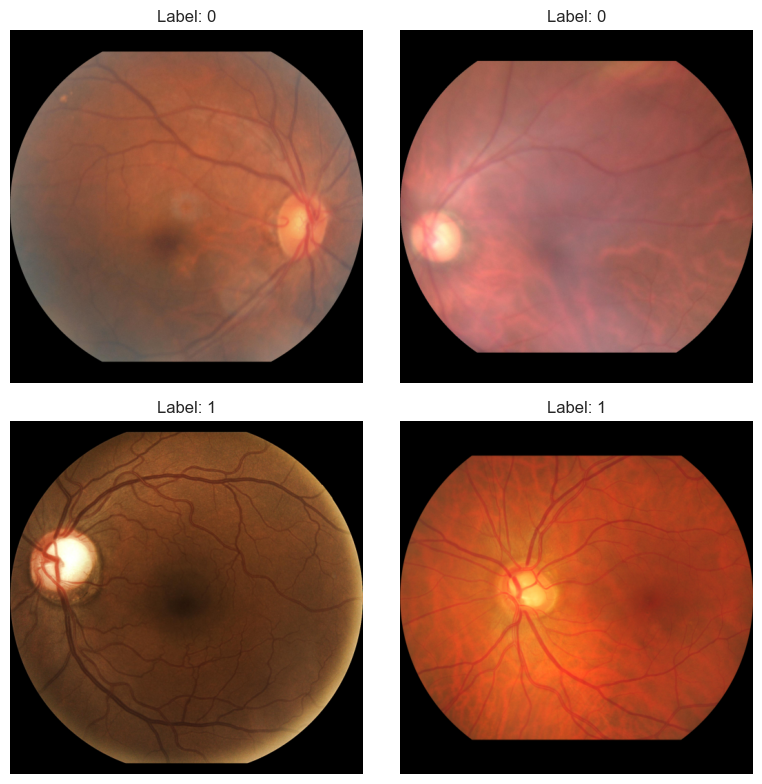

In [9]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Define the destination folder and function as before
destination_folder = 'full-fundus/full-fundus'

# Modify the function to display images as needed
def display_images(df, rows, cols, dest):
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    for r in range(rows):
        for c in range(cols):
            index = r * cols + c
            if index < len(df):
                img_path = df.iloc[index]['names'] + '.png'
                image_path = os.path.join(dest, img_path)
                label = df.iloc[index]['types']
                img = Image.open(image_path)
                axes[r, c].imshow(img)
                axes[r, c].set_title(f'Label: {label}')
                axes[r, c].axis('off')
            else:
                axes[r, c].axis('off')
    plt.tight_layout()
    plt.show()

# Select 2 images per label (0 and 1)
sampled_df = df.groupby('types').apply(lambda x: x.sample(n=2)).reset_index(drop=True)

# Display the selected images
rows, cols = 2, 2  # Since we are displaying 4 images (2 per label)
display_images(sampled_df, rows, cols, destination_folder)


In [10]:
import os
from PIL import Image
from collections import Counter

# Define the path to the dataset folder
destination_folder = 'full-fundus/full-fundus'

# Initialize a Counter to store image sizes
image_sizes = Counter()

# Iterate through each image in the dataset folder
for image_name in os.listdir(destination_folder):
    # Ensure the file is an image (e.g., png, jpg, etc.)
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Get the full path of the image
        image_path = os.path.join(destination_folder, image_name)
        # Open the image and get its size
        with Image.open(image_path) as img:
            size = img.size  # (width, height)
            image_sizes[size] += 1

# Display the different image sizes and their counts
print("Image sizes and their counts:")
for size, count in image_sizes.items():
    print(f"Size {size}: {count} images")


Image sizes and their counts:
Size (512, 512): 12449 images


In [11]:
#extracting refuge dataset with refuge_df, refuge_train, refuge_val
refuge_df = df[df['names'].str.contains("REFUGE")]
refuge_df['types'].value_counts()

types
0    720
1     80
Name: count, dtype: int64

In [12]:
#extracting origa dataset with origa_df


origa_df = df[df['names'].str.contains("ORIGA")]
origa_df['types'].value_counts()

types
0    482
1    168
Name: count, dtype: int64

In [13]:
g1020_df = df[df['names'].str.contains("G1020")]
g1020_df['types'].value_counts()

types
0    724
1    296
Name: count, dtype: int64

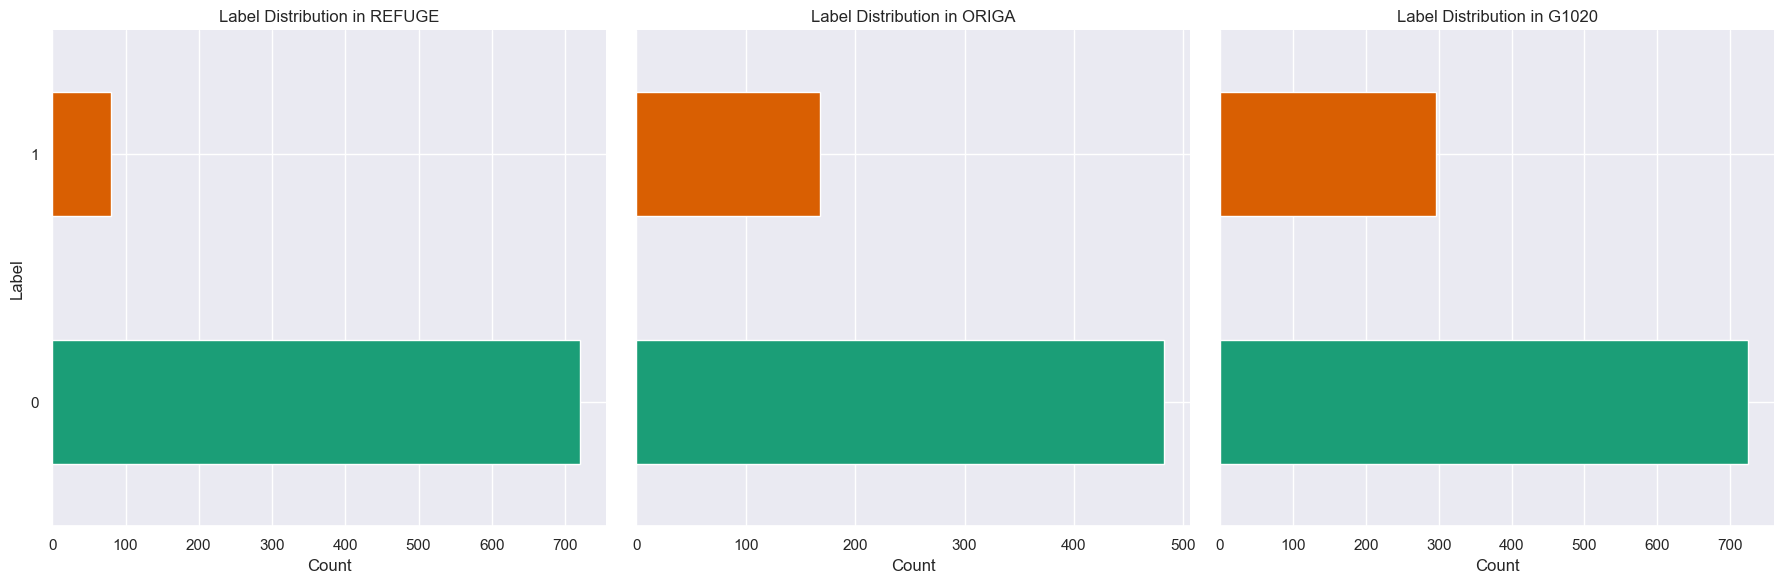

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot label distribution for each DataFrame
for ax, dataset_df, title in zip(axes, [refuge_df, origa_df, g1020_df], ["REFUGE", "ORIGA", "G1020"]):
    dataset_df.groupby('types').size().plot(kind='barh', ax=ax, color=sns.color_palette('Dark2'))
    ax.set_title(f'Label Distribution in {title}')
    ax.set_xlabel('Count')
    ax.spines[['top', 'right']].set_visible(False)

# Set a common y-label for all plots
axes[0].set_ylabel('Label')

# Display the figure
plt.tight_layout()
plt.show()

In [15]:
three_sets_df = pd.concat([g1020_df, origa_df, refuge_df])
three_sets_df = three_sets_df.copy().reset_index(drop=True, inplace=False)
three_sets_df

,names,types
0,G1020-1,0
1,G1020-2,0
2,G1020-3,0
3,G1020-4,0
4,G1020-5,0
...,...,...
2465,REFUGE1-val-396,0
2466,REFUGE1-val-397,0
2467,REFUGE1-val-398,0
2468,REFUGE1-val-399,0


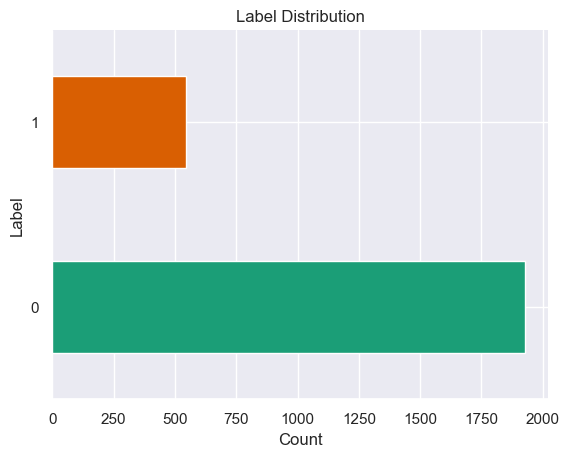

In [16]:
import matplotlib.pyplot as plt

# Group by 'label' and count the occurrences, then plot as a horizontal bar chart
three_sets_df.groupby('types').size().plot(kind='barh', color=sns.color_palette('Dark2'))

# Customize the plot to match the style
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Label Distribution')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


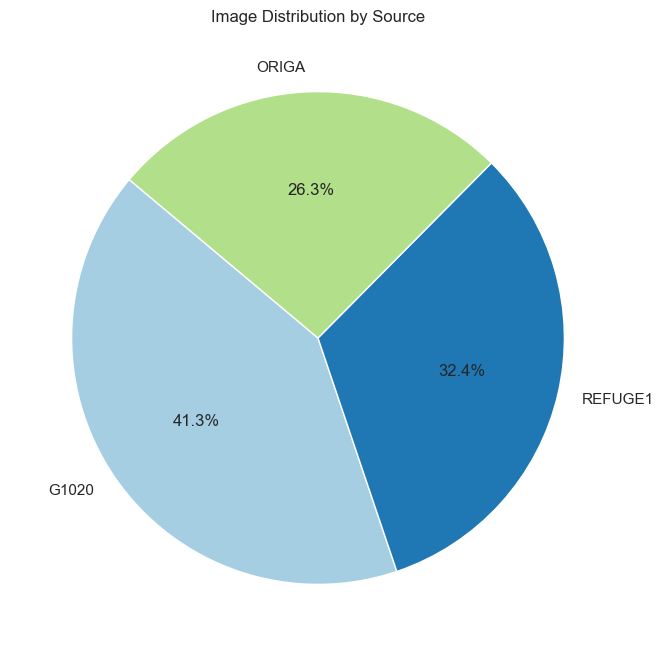

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract prefixes from the 'names' column (assuming prefixes are separated by a hyphen)
three_sets_df['source'] = three_sets_df['names'].str.split('-').str[0]

# Count the occurrences of each source
source_counts = three_sets_df['source'].value_counts()

# Plot the distribution as a pie chart
plt.figure(figsize=(8, 8))
source_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Customize the plot
plt.title('Image Distribution by Source')
plt.ylabel('')  # Remove the y-label for a cleaner look
plt.show()


In [18]:
three_sets_df['types'].value_counts()

types
0    1926
1     544
Name: count, dtype: int64

In [19]:
# Assuming 'names' and 'types' columns are the common columns to match on
# Merge df and three_sets_df and keep only entries that are unique to df
df_remaining = df.merge(three_sets_df[['names', 'types']], on=['names', 'types'], how='left', indicator=True)

# Filter rows that are only in df (not in three_sets_df)
df_remaining = df_remaining[df_remaining['_merge'] == 'left_only']

# Drop the '_merge' column which was added by the merge function
df_remaining = df_remaining.drop(columns=['_merge'])

# Check how many are left
remaining_count = df_remaining.shape[0]
print(f"Number of entries left in df after dropping those in three_sets_df: {remaining_count}")
df_remaining['types'].value_counts()

df_remaining['types'].sum()

Number of entries left in df after dropping those in three_sets_df: 9846


4223

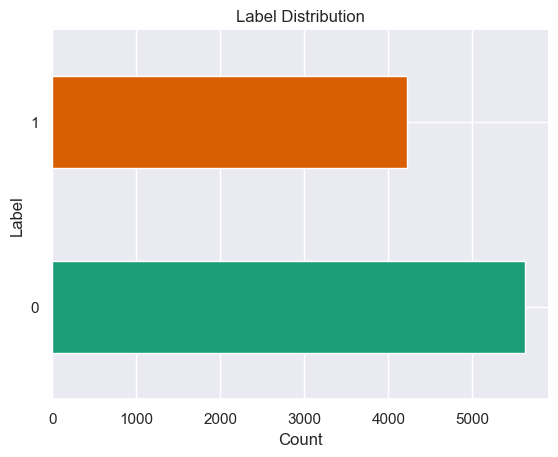

In [20]:
import matplotlib.pyplot as plt

# Group by 'label' and count the occurrences, then plot as a horizontal bar chart
df_remaining.groupby('types').size().plot(kind='barh', color=sns.color_palette('Dark2'))

# Customize the plot to match the style
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Label Distribution')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


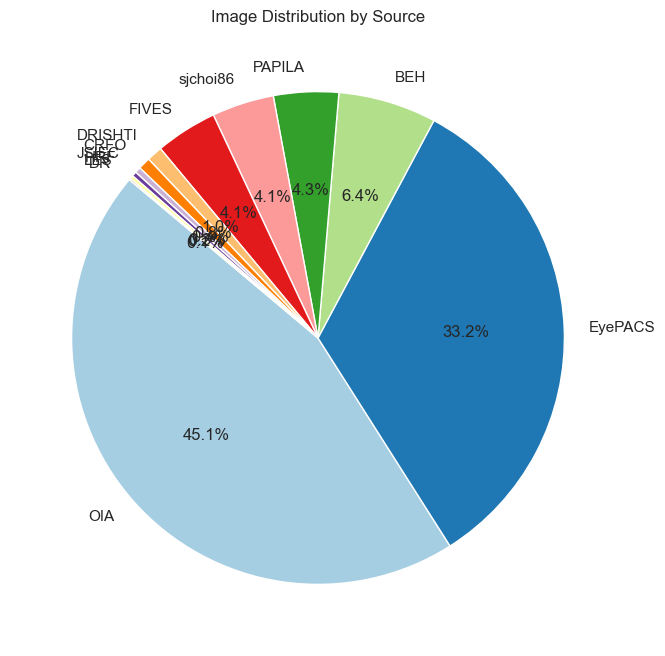

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract prefixes from the 'names' column (assuming prefixes are separated by a hyphen)
df_remaining['source'] = df_remaining['names'].str.split('-').str[0]

# Count the occurrences of each source
source_counts = df_remaining['source'].value_counts()

# Plot the distribution as a pie chart
plt.figure(figsize=(8, 8))
source_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Customize the plot
plt.title('Image Distribution by Source')
plt.ylabel('')  # Remove the y-label for a cleaner look
plt.show()


In [23]:

# for full-fundus - 3sets ROI

glaucoma_remaining_df = df_remaining[df_remaining['types'] == 1]
non_glaucoma_remaining_df = df_remaining[df_remaining['types'] == 0]

# Define the image folder
image_folder = 'full-fundus/full-fundus/processed_roi'
dest= 'dataset/3_dataset/remaining_roi_full_rgb_labeled'

# Get the list of image filenames in the folder
image_files = os.listdir(image_folder)

# Remove the file extension to get the image names without extensions
image_names_no_ext = [os.path.splitext(image_file)[0] for image_file in image_files]


def move_images(dataframe, images_folder, destination_folder):
    for index, row in dataframe.iterrows():
        image_name = row['names'] + '.tiff'
        label = 'glaucoma' if row['types'] == 1 else 'healthy'
        
        destination_label_folder = os.path.join(destination_folder, label)
        os.makedirs(destination_label_folder, exist_ok=True)
        
        source_path = os.path.join(images_folder, image_name)
        destination_path = os.path.join(destination_label_folder, image_name)
        
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
        else:
            print(f"File not found, skipping: {source_path}")

# Move the training images
move_images(non_glaucoma_remaining_df, image_folder, dest)


File not found, skipping: full-fundus/full-fundus/processed_roi\OIA-ODIR-TEST-OFFLINE-11.tiff
File not found, skipping: full-fundus/full-fundus/processed_roi\OIA-ODIR-TEST-OFFLINE-29.tiff
File not found, skipping: full-fundus/full-fundus/processed_roi\OIA-ODIR-TEST-OFFLINE-31.tiff
File not found, skipping: full-fundus/full-fundus/processed_roi\OIA-ODIR-TEST-OFFLINE-37.tiff
File not found, skipping: full-fundus/full-fundus/processed_roi\OIA-ODIR-TEST-OFFLINE-39.tiff
File not found, skipping: full-fundus/full-fundus/processed_roi\OIA-ODIR-TEST-OFFLINE-48.tiff
File not found, skipping: full-fundus/full-fundus/processed_roi\OIA-ODIR-TEST-OFFLINE-54.tiff
File not found, skipping: full-fundus/full-fundus/processed_roi\OIA-ODIR-TEST-OFFLINE-71.tiff
File not found, skipping: full-fundus/full-fundus/processed_roi\OIA-ODIR-TEST-OFFLINE-73.tiff
File not found, skipping: full-fundus/full-fundus/processed_roi\OIA-ODIR-TEST-OFFLINE-121.tiff
File not found, skipping: full-fundus/full-fundus/processed

In [9]:

# Paths
image_folder = 'full-fundus/full-fundus/processed_roi'        # Path to the folder containing all images
output_folder = 'dataset/3_dataset/ORG'       # Path to the main output folder

# Create a temporary folder for filtered images
filtered_folder = os.path.join(output_folder, 'filtered_images')
os.makedirs(filtered_folder, exist_ok=True)

# Create healthy and diseased folders inside the filtered folder
healthy_folder = os.path.join(filtered_folder, 'healthy')
diseased_folder = os.path.join(filtered_folder, 'diseased')
os.makedirs(healthy_folder, exist_ok=True)
os.makedirs(diseased_folder, exist_ok=True)

# List of target dataset prefixes
target_datasets = ['ORIGA', 'REFUGE', 'G1020']

for filename in os.listdir(image_folder):
    # Check if the filename starts with any of the target datasets
    if any(filename.startswith(prefix) for prefix in target_datasets):
        src = os.path.join(image_folder, filename)
        dest = os.path.join(filtered_folder, filename)
        shutil.copy(src, dest)  # Use shutil.move(src, dest) to move instead of copy




In [16]:
metadata = pd.read_csv(original_csv_path)
for _, row in metadata.iterrows():
    filename = row['names']
    label = row['types']
    
    # Convert filename to filename.tiff
    filename_tiff = filename +'.tiff'
    src = os.path.join(filtered_folder, filename_tiff)
    print(src)
    # Check if the file is in the filtered folder
    if os.path.exists(src):
        # Determine destination based on label
        if label == '0':
            dest = os.path.join(healthy_folder, filename_tiff)
            print(dest)
        elif label == '1':
            dest = os.path.join(diseased_folder, filename_tiff)
            print(dest)
        else:
            continue  # Skip if label is neither "healthy" nor "diseased"
        
        # Move or copy file
        shutil.copy(src, dest)  # Move instead of copy to avoid duplication
        print(f"File {filename_tiff} not found in filtered folder")
    else:
        #print(f"File {filename_tiff} not found in filtered folder")
        pass
print("Dataset division completed.")

dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-1.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-2.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-4.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-5.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-6.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-7.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-8.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-9.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-10.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-11.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-12.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-13.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-14.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFLINE-15.tiff
dataset/3_dataset/ORG\filtered_images\OIA-ODIR-TEST-OFFL